In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
Image_Size=256
BATCH_SIZE=32
Channels=3
epochs=50

In [3]:
data=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/PlantVillage',
    shuffle=True,
    image_size=(Image_Size,Image_Size),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(data)

68

In [6]:
for image_batch,label_batch in data.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 2 0 0 0 1 0 1 0 1 0 0 0 2]


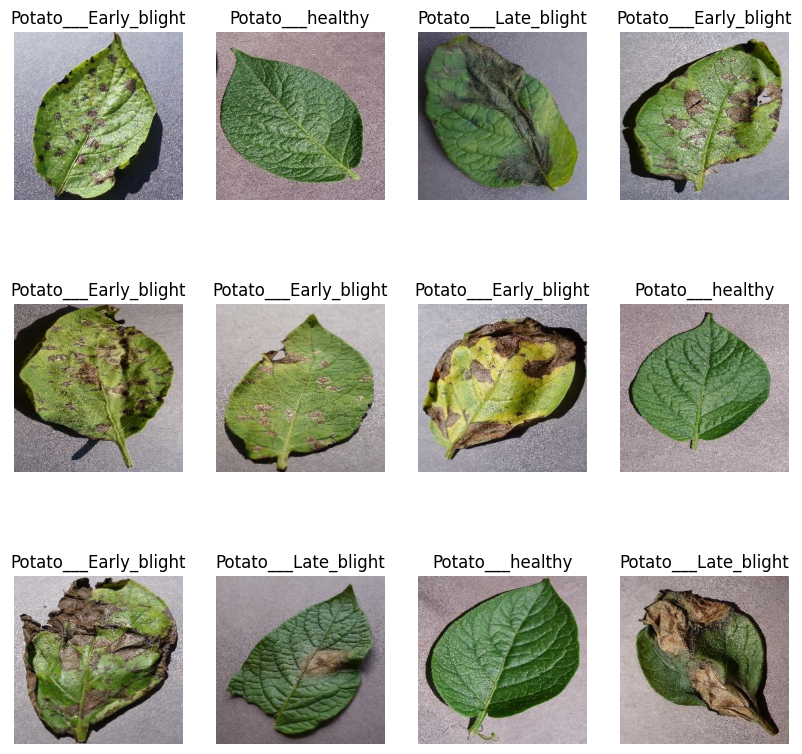

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in data.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

###Function to Split Dataset
####Dataset should be bifurcated into 3 subsets, namely:
####Training: Dataset to be used while training
####Validation: Dataset to be tested against while training
####Test: Dataset to be tested against after we trained a model

In [8]:
train_size=0.8
len(data)*train_size

54.400000000000006

In [9]:
train_data=data.take(54)
len(train_data)

54

In [10]:
test_data=data.skip(54)
len(test_data)

14

In [11]:
val_size=0.1
len(data)*val_size

6.800000000000001

In [12]:
val_data=test_data.take(6)
len(val_data)

6

In [13]:
test_data=test_data.skip(6)
len(test_data)

8

In [14]:
def get_dataset_partitions_tf(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(data)

In [16]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [17]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
input_shape=(BATCH_SIZE,Image_Size,Image_Size,Channels)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    ])
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history=model.fit(
    train_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 260s 3s/step - loss: 0.9026 - accuracy: 0.5064 - val_loss: 0.9296 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 132s 2s/step - loss: 0.7131 - accuracy: 0.6950 - val_loss: 0.5933 - val_accuracy: 0.7708
Epoch 3/50
54/54 [==============================] - 133s 2s/step - loss: 0.4852 - accuracy: 0.8032 - val_loss: 0.3912 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 131s 2s/step - loss: 0.3042 - accuracy: 0.8814 - val_loss: 0.2319 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 133s 2s/step - loss: 0.2491 - accuracy: 0.8981 - val_loss: 0.3270 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 132s 2s/step - loss: 0.2002 - accuracy: 0.9219 - val_loss: 0.1720 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 133s 2s/step - loss: 0.1713 - accuracy: 0.9323 - val_loss: 0.2467 - val_accuracy: 0.8958
Epoch 8/50
54

In [24]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 10s 606ms/step - loss: 0.3644 - accuracy: 0.9102


In [25]:
scores

[0.36444181203842163, 0.91015625]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
len(history.history['accuracy'])

50

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

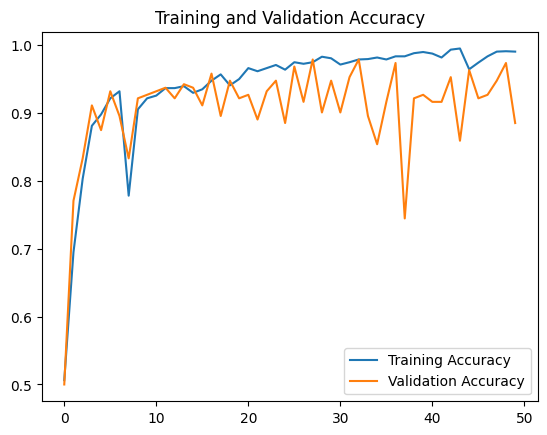

In [45]:
plt.plot(range(epochs),acc,label='Training Accuracy')
plt.plot(range(epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

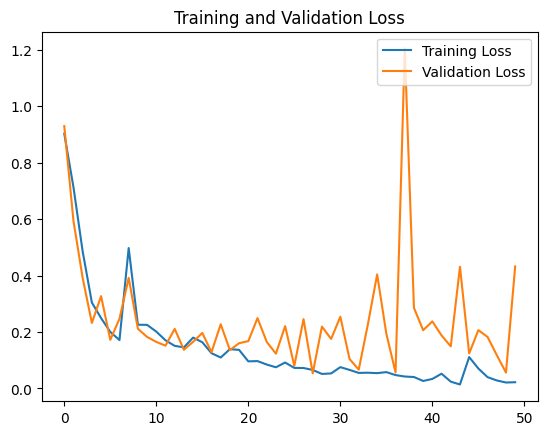

In [46]:
plt.plot(range(epochs),loss,label='Training Loss')
plt.plot(range(epochs),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First Image to Predict
First Image Actual Label :  Potato___Early_blight
1/1 [==============================] - 1s 1s/step
Predicted Label:  Potato___Early_blight


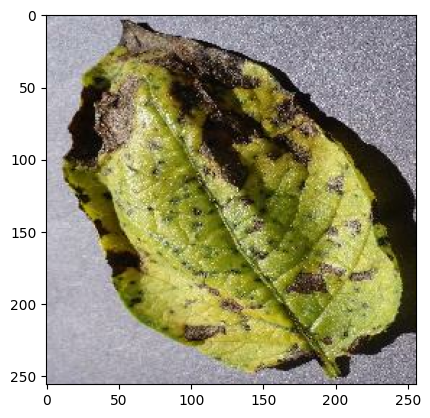

In [33]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()
  print('First Image to Predict')
  plt.imshow(first_image)
  print('First Image Actual Label : ',class_names[first_label])
  batch_prediction=model.predict(images_batch)
  print('Predicted Label: ',class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0) #create a batch
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 46ms/step


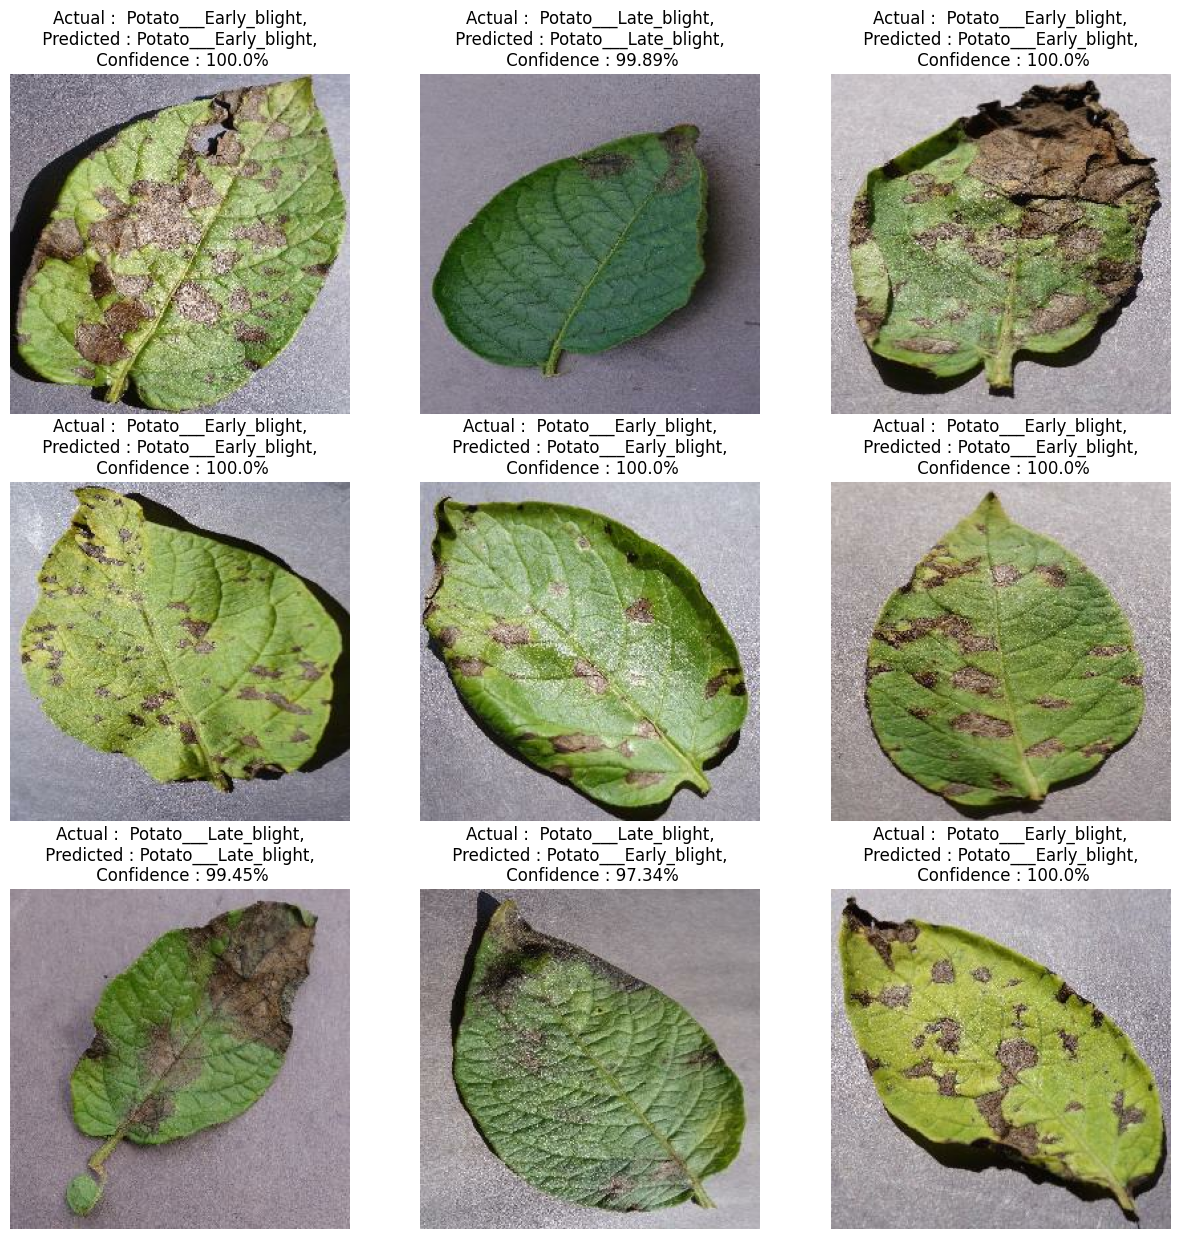

In [41]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual :  {actual_class},\n Predicted : {predicted_class}, \n Confidence : {confidence}%")
    plt.axis('off')